# Notebook associated with the manuscript on FAIR-BioRS

## Import required packages and set high-level constants

In [48]:
import collections
import math
import os
import re
import textwrap
import time
import requests
import yaml

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from github import Github
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D

In [49]:
COLOR_1 = "#2563EB"
COLOR_2 = "#ffd166"
COLOR_3 = "#06d6a0"
COLOR_4 = "#118ab2"
COLOR_5 = "#ef476f"
COLOR_6 = "#fb5607"
color_palette = [COLOR_1, COLOR_2, COLOR_3, COLOR_4, COLOR_5, COLOR_6]

%matplotlib inline
pd.set_option("display.max_colwidth", None)

sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)
sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

current_folder = os.getcwd()

## General functions

In [50]:
def create_folder_if_not_exist(folder_path):
    """
    Create a folder at the path specified by folder_path
    if such a folder does not exist

    Args:
        folder_path: full path of the folder to create

    Returns:
        folder_path: full path of the folder created

    """
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)
    return folder_path


def save_image(fig, folder_path, plot_name, output_format):
    """
    Save a matplotlib fig to png image file

    Args:
        fig: matplotlib fig object
        folder_path: full path of the folder where image will be created
        plot_name: name of the image file to be created
        output_format: format of the image file to be created
                        ('png' or 'svg' typically)

    Returns:
        'Saved successfully'

    """
    folder_path = create_folder_if_not_exist(folder_path)
    file_name = plot_name + "." + output_format
    file_path = os.path.join(folder_path, file_name)
    fig.savefig(file_path, bbox_inches="tight")
    return "Saved successfully"


def frenquency_suggestions(df_sub):
    """
    Counts how many time an item is included in dataframe column

    Args:
        df_sub: dataframe of interest

    Returns:
        frequency: dictionary where keys are unique items from the dataframe
                    column and the values are their respective frequencies

    """
    list_suggestions = list(df_sub.values)
    list_suggestions_cleaned = []
    for item in list_suggestions:
        item = item.split(";")
        list_suggestions_cleaned.extend(item)
    list_suggestions_cleaned = [x.strip() for x in list_suggestions_cleaned]
    frequency_all = dict(collections.Counter(list_suggestions_cleaned))
    frequency = dict(
        sorted(frequency_all.items(), key=lambda item: item[1], reverse=True)
    )
    return frequency


def generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
):
    """
    Generate bar plot of interest

    Args:
        x: x axis list for the plot
        y: y axis value for the plot
        fig_width: width of the figure (in inch)
        fig_height: height of the figure (in inch)
        bar_width: width of the bars (in inch)
        delta_y: offset of the bar labels w.r.t. the top of the corresponding
                 bar
        x_label: x labels of the figure
        title: Title of the figure

    Returns:
        fig: Matplotlib top level container for all the plot elements

    """
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    bars = ax.bar(x, y, bar_width, color=color_palette[0])
    for bar in bars:
        yval = bar.get_height()
        xval = bar.get_x()
        w = bar.get_width()
        ax.text(
            xval + w / 2,
            yval + delta_y,
            round(yval, 1),
            horizontalalignment="center",
        )
    if max_width_x_tick_labels:
        ax.set_xticklabels(
            textwrap.fill(label_x, max_width_x_tick_labels) for label_x in x
        )
    else:
        ax.set_xticks(x)
    ax.set_yticks(range(0, max(y) + 1, y_ticks_increment))
    ax.grid(axis="y", color="#EEEEEE")
    ax.set_axisbelow(True)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.spines["left"].set_visible(False)
    ax.set_xlabel(x_label, labelpad=15, color="#333333")
    plt.ylabel(y_label, fontsize=18)
    plt.title(
        title,
        color="#333333",
        fontsize=20,
        y=1.05,
    )
    plt.xticks(rotation=90, ha="center")
    fig.tight_layout()
    return fig

## Number of biomedical related repositories on GitHub 

In [82]:
def search_github_repo_created_month(keywords, created_month, language):
    """
    Get number of repositories on GitHub with "biomedical" included in the
    name, readme, or description created in a given month of a year.
    We do month-wise search since the GitHub API has a result rate limit of 1000
    assuming no single month has more than 1000 results

    Args:
        keywords: keyword to search on GitHub
        created_month: month of interest for the search
        language: major programming language of the target repositories

    Returns:
        result: GitHub query result

    """
    created_month_query = " created:" + created_month
    language_query = " language:" + language
    query = (
        keywords  + " in:readme" + " in:description" + language_query + created_month_query
    )
    result = g.search_repositories(query)
    return result

### Approach #1: Filter by all programming languages recognized by GitHub
To get the number of repositories new created on GitHub in a given year with "biomedical" included in their readme or description
and count only repositories that contain software (not only data) we proceeded as follows:
1. Get a list of all programming language recognized by GitHub using https://github.com/github-linguist/linguist/blob/master/lib/linguist/languages.yml
2. Create the search query to include only repositories that have one of the programming langues from the list as their major coding language
3. Search on GitHub using the API
4. Save results in a csv file under the "input" folder
5. Use that file to generate the plot of biomedical related software repositories created vs year

This turned out to be very time consuming to run at step #3 given the GitHub rate limit and large number of programming languages recognized by GitHub and was therefore **not pursued**.

In [155]:
# To make sure we only count software repositories and exclude any data only repositories, 
# We first got a list of all programming languages recognized by GitHub to use in our search
url = "https://raw.githubusercontent.com/github-linguist/linguist/master/lib/linguist/languages.yml"
response = requests.get(url, allow_redirects=True)
# Convert bytes to string
content = response.content.decode("utf-8")
# Load the yaml
languages_yml = yaml.safe_load(content)
languages_software_list = []
for key in languages_yml:
    if languages_yml[key]["type"] == "programming":
        languages_software_list.append(key)
print(languages_software_list)

['1C Enterprise', '4D', 'ABAP', 'ABAP CDS', 'AGS Script', 'AIDL', 'AL', 'AMPL', 'ANTLR', 'APL', 'ASL', 'ASP.NET', 'ATS', 'ActionScript', 'Ada', 'Agda', 'Alloy', 'Alpine Abuild', 'AngelScript', 'Apex', 'Apollo Guidance Computer', 'AppleScript', 'Arc', 'AspectJ', 'Assembly', 'Asymptote', 'Augeas', 'AutoHotkey', 'AutoIt', 'Awk', 'BASIC', 'Ballerina', 'Batchfile', 'Beef', 'Befunge', 'Berry', 'Bicep', 'Bison', 'BitBake', 'BlitzBasic', 'BlitzMax', 'Bluespec', 'Boo', 'Boogie', 'Brainfuck', 'BrighterScript', 'Brightscript', 'C', 'C#', 'C++', 'C2hs Haskell', 'CAP CDS', 'CLIPS', 'CMake', 'COBOL', 'CUE', 'CWeb', 'Cadence', 'Cairo', 'CameLIGO', "Cap'n Proto", 'CartoCSS', 'Ceylon', 'Chapel', 'Charity', 'ChucK', 'Circom', 'Cirru', 'Clarion', 'Clarity', 'Classic ASP', 'Clean', 'Click', 'Clojure', 'CodeQL', 'CoffeeScript', 'ColdFusion', 'ColdFusion CFC', 'Common Lisp', 'Common Workflow Language', 'Component Pascal', 'Cool', 'Coq', 'Crystal', 'Csound', 'Csound Document', 'Csound Score', 'Cuda', 'Curry'

In [ ]:
# Run gitHub search
# Skip if running on Binder
GITHUB_ACCESS_TOKEN = os.getenv("GITHUB_ACCESS_TOKEN")
g = Github(GITHUB_ACCESS_TOKEN)
print("Success: GitHub Access Token loaded")

keywords = "biomedical"
start_year = 2010
end_year = 2022
year_list = [str(x) for x in range(start_year, end_year + 1)]
month_list = ["%.2d" % x for x in range(1, 13)]
df = pd.DataFrame(columns=["year", "month", "language", "count"])
search_count = 0
search_limit = 30
for year in year_list:
    for month in month_list:
        print(year, month)
        created_month = year + "-" + month
        for language in languages_software_list:
            result = search_github_repo_created_month(keywords, created_month, language)
            df.loc[len(df.index)] = [year, month, language, result.totalCount]
            search_count += 1
            if search_count == search_limit:
                time.sleep(65)
                search_count = 0
print(
    "Success: Month-wise number of repositories created on GitHub between "
    + str(start_year)
    + " and "
    + str(end_year)
    + " with keyword biomedical pulled and saved in a dataframe"
)

# get year wise results
df_yearwise = pd.DataFrame(columns=["year", "count"])
for year in year_list:
    df_sub = df[df["year"] == year]
    total = df_sub["count"].sum()
    df_yearwise.loc[len(df_yearwise.index)] = [year, total]
df_yearwise.to_csv("input/github_biomedical_repo_count_yearwise.csv")
print(
    "Success: Year-wise number of repositories created on GitHub between "
    + str(start_year)
    + " and "
    + str(end_year)
    + " with keyword biomedical calculated saved in a dataframe and in a csv file"
)

print(df_yearwise)

### Approach #2: Filter by only by popular programming languages
To get the number of repositories new created on GitHub in a given year with "biomedical" included in their readme or description
and count only repositories that contain software (not only data) we proceeded as follows:
1. Get a list of all popular programming language as established by GitHub using https://github.com/github-linguist/linguist/blob/master/lib/linguist/popular.yml. They seem relevant to popular languages for biomedical research software development
2. Create the search query to include only repositories that have one of the popular programming langues from the list as their major coding language
3. Search on GitHub webUI
4. Save results in a csv file under the "input" folder
5. Use that file to generate the plot of biomedical related software repositories created vs year

This approach was more reasonable to run and was therefore used to generate our figure.

In [85]:
# Get list of popular programming languages established by GitHub to use in our search
url = "https://raw.githubusercontent.com/github-linguist/linguist/master/lib/linguist/popular.yml"
response = requests.get(url, allow_redirects=True)
# Convert bytes to string
content = response.content.decode("utf-8")
# Load the yaml
popular_languages_yml = yaml.safe_load(content)

# Add additional languages popular in biomedical software
print(popular_languages_software_list)

['C', 'C#', 'C++', 'CoffeeScript', 'CSS', 'Dart', 'DM', 'Elixir', 'Go', 'Groovy', 'HTML', 'Java', 'JavaScript', 'Kotlin', 'Objective-C', 'Perl', 'PHP', 'PowerShell', 'Python', 'Ruby', 'Rust', 'Scala', 'Shell', 'Swift', 'TypeScript']


In [94]:
# Create search query for the GitHub webUI
keywords = "biomedical"
start_year = 2010
end_year = 2022
year_list = [str(x) for x in range(start_year, end_year+1)]
search_in = " in:name,topics,description,readme"
for language in popular_languages_software_list:
    language_query += " language:\"" + language + "\""
for year in year_list:
    created_year_query = " created:" + year
    query = keywords + search_in + created_year_query + language_query
    print(year)
    print(query)

2010
biomedical in:name,topics,description,readme created:2010 language:"C" language:"C#" language:"C++" language:"CoffeeScript" language:"CSS" language:"Dart" language:"DM" language:"Elixir" language:"Go" language:"Groovy" language:"HTML" language:"Java" language:"JavaScript" language:"Kotlin" language:"Objective-C" language:"Perl" language:"PHP" language:"PowerShell" language:"Python" language:"Ruby" language:"Rust" language:"Scala" language:"Shell" language:"Swift" language:"TypeScript" language:"C" language:"C#" language:"C++" language:"CoffeeScript" language:"CSS" language:"Dart" language:"DM" language:"Elixir" language:"Go" language:"Groovy" language:"HTML" language:"Java" language:"JavaScript" language:"Kotlin" language:"Objective-C" language:"Perl" language:"PHP" language:"PowerShell" language:"Python" language:"Ruby" language:"Rust" language:"Scala" language:"Shell" language:"Swift" language:"TypeScript"
2011
biomedical in:name,topics,description,readme created:2011 language:"

In [70]:
# visualize year-wise results
github_input_file = "https://raw.githubusercontent.com/fairdataihub/FAIR-BioRS-code/main/input/github_biomedical_repo_count_yearwise.csv"
df = pd.read_csv(
    github_input_file
)  # or use df = df_yearwise if not working from pre-saved results
x = df["year"]
y = df["count"]
fig_width = 8
fig_height = 6
bar_width = 0.6
delta_y = 20
x_label = "Year created"
y_label = ""
max_width_x_tick_labels = ""
y_ticks_increment = 1000
title = "Number of repositories created on GitHub \n with 'biomedical' in the name, description, or readme"
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "github-biomedical-repo-count-yearwise"
save_image(fig, "output", plot_name, "png")

HTTPError: HTTP Error 404: Not Found

## Review analysis

In [51]:
# Load review data
data_file_location = "https://github.com/FAIR-BioRS/Data/blob/main/primary/data.xlsx?raw=true"
df = pd.read_excel(data_file_location, engine="openpyxl", sheet_name="resourcesReviewKeywords")
print("Data loaded successfuly")
df.head()

Data loaded successfuly


,count,countGroup,added2023,reviewGroup,doiOrLink,firstAuthor,year,title,foundThrough,mentionsFAIR,...,dataFileHelp,metadataFilesSuggestion,metadataHelp,licenseSuggestion,licenseHelp,repositorySuggestion,repositoryHelp,registerySuggestion,registeryHelp,FAIRhelp
0,1,1,yes,1,https://doi.org/10.1038/s41597-022-01710-x,Barker,2022.0,Introducing the FAIR Principles for research software,NaN,yes,...,NaN,CodeMeta,NaN,Apache 2.0; GNU GPL v3,NaN,Zenodo; HAL; Software Heritage,NaN,bio.tools; Research Software Directory,NaN,NaN
1,2,2,yes,1,https://doi.org/10.15497/RDA00068,Chue Hong,2022.0,FAIR Principles for Research Software (FAIR4RS Principles) v 1.0,NaN,yes,...,NaN,NaN,NaN,NaN,"https://spdx.dev/; The FAIR4RS Principles can be applied to any research software, regardless of the license. To support a wide range of reuse scenarios, the license should be as unrestrictive as possible and, to avoid license proliferation",NaN,NaN,NaN,NaN,NaN
2,3,3,no,1,https://doi.org/10.15497/RDA00065,Chue Hong,2021.0,FAIR Principles for Research Software (FAIR4RS Principles),NaN,yes,...,NaN,CodeMeta,NaN,Open source licenses,https://spdx.dev/,NaN,NaN,NaN,NaN,NaN
3,4,4,no,1,https://doi.org/10.1016/j.patter.2021.100222,Katz,2020.0,Taking a fresh look at FAIR for research software,NaN,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5,yes,1,https://arxiv.org/abs/2101.10883v4,Katz,2021.0,A Fresh Look at FAIR for Research Software,https://doi.org/10.1016/j.patter.2021.100222,yes,...,NaN,CodeMeta,https://codemeta.github.io/codemeta-generator/,NaN,NaN,Zenodo; Software Heritage,NaN,Zenodo,NaN,NaN


In [53]:
# Number of relevant studies in the review
df_sub = df[df["isRelevant"] == "yes"]
total_relevant_studies = len(df_sub)
print(str(total_relevant_studies) + " relevant studies were included in the review")
# Number of relevant studies per category
for group in range(1,6):
    df_sub = df[(df["isRelevant"] == "yes") & (df["reviewGroup"] == group)]
    total_relevant_studies_group = len(df_sub)
    print(str(total_relevant_studies_group) + " relevant studies were included in the review from group " + str(group))

39 relevant studies were included in the review
6 relevant studies were included in the review from group 1
11 relevant studies were included in the review from group 2
7 relevant studies were included in the review from group 3
1 relevant studies were included in the review from group 4
14 relevant studies were included in the review from group 5


### Category 1: Develop software following standards and best practices

#### Standards

In [54]:
# Number of studies
df_sub = df[["doiOrLink", "title", "standardsSuggestion"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about the standards to follow when developing a research software"
)
display(df_sub)

From the reviewed studies, 2 made a suggestion about the standards to follow when developing a research software


,doiOrLink,title,standardsSuggestion
0,https://doi.org/10.1038/s41597-022-01710-x,Introducing the FAIR Principles for research software,CSV files
1,https://doi.org/10.15497/RDA00068,FAIR Principles for Research Software (FAIR4RS Principles) v 1.0,Common Workflow Language; \nR community standards for creating\npackages; PEP 8 Style Guide for Python Code


In [55]:
df_sub = df[["doiOrLink", "title", "standardsHelp"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about resources to help with standards"
)
display(df_sub)

From the reviewed studies, 3 made a suggestion about resources to help with standards


,doiOrLink,title,standardsHelp
1,https://doi.org/10.15497/RDA00068,FAIR Principles for Research Software (FAIR4RS Principles) v 1.0,https://fairsharing.org/standards/
2,https://doi.org/10.15497/RDA00065,FAIR Principles for Research Software (FAIR4RS Principles),https://fairsharing.org/standards/
24,https://doi.org/10.37044/osf.io/k8znb,ELIXIR Software Management Plan for Life Sciences,GA4GH; https://fairsharing.org/standards/


#### Best practices

In [56]:
# Number of studies
df_sub = df[["doiOrLink", "title", "bestPracticeSuggestion", "added2023"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about the best practices to follow when developing a research software"
)
display(df_sub)

From the reviewed studies, 21 made a suggestion about the best practices to follow when developing a research software


,doiOrLink,title,bestPracticeSuggestion,added2023
0,https://doi.org/10.1038/s41597-022-01710-x,Introducing the FAIR Principles for research software,Develop with a version control system platform (GitHub); Record dependencies (in code),yes
1,https://doi.org/10.15497/RDA00068,FAIR Principles for Research Software (FAIR4RS Principles) v 1.0,"Record dependencies (requirements, imports, libraries)",yes
4,https://arxiv.org/abs/2101.10883v4,A Fresh Look at FAIR for Research Software,Develop with a version control system platform,yes
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,"Develop with a version control system platform (GitHub, Bitbucket); Use container technologies (Docker)",no
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,Make code modular; Have code level documentation; Provide tests; Develop with a version control system platform,no
20,https://doi.org/10.5281/zenodo.4310217,"Five recommendations for ""FAIR software""","Develop with a version control system platform (GitHub, Bitbucket, GitLab)",no
24,https://doi.org/10.37044/osf.io/k8znb,ELIXIR Software Management Plan for Life Sciences,"Develop with a version control system platform (GitHub, Bitbucket, GitLab); Have code level documentation; Provide tests; Have code level documentation (Docstring, comments); Record dependencies (Maven for Java, requirements.txt or environment.yml for Python, package.json for JavaScript); Use container technologies",yes
29,https://doi.org/10.1515/itit-2019-0040,From FAIR research data toward FAIR and open research software,Make code modular; Use container technologies (Docker); Develop with a version control system platform (GitHub),no
32,https://doi.org/10.12688/f1000research.23224.2,"An Environment for Sustainable Research Software in Germany and beyond: Current State, Open Challenges, and Call for Action",Use container technologies (Docker),no
40,https://doi.org/10.5281/zenodo.6258366,FAIR4RS: Adoption support,Develop with a version control system platform (GitHub),yes


In [57]:
# Frequency of suggestions
list_suggestions = df_sub["bestPracticeSuggestion"]
list_suggestions_cleaned = []
for item in list_suggestions:
    item = item.split(";")
    item = [re.sub("[\(\[].*?[\)\]]", "", x) for x in item]
    item = [x.strip() for x in item]
    list_suggestions_cleaned.extend(item)
list_suggestions_unique = list(set(list_suggestions_cleaned))
frequency = {}
for item in list_suggestions_unique:
    df_sub2 = df_sub[df_sub["bestPracticeSuggestion"].str.contains(item)]
    frequency[item] = len(df_sub2)
    print(item, frequency[item])
    display(df_sub2)
frequency = dict(sorted(frequency.items(), key=lambda item: item[1], reverse=True))
print(frequency)

Make code modular 2


,doiOrLink,title,bestPracticeSuggestion,added2023
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,Make code modular; Have code level documentation; Provide tests; Develop with a version control system platform,no
29,https://doi.org/10.1515/itit-2019-0040,From FAIR research data toward FAIR and open research software,Make code modular; Use container technologies (Docker); Develop with a version control system platform (GitHub),no


Develop with a version control system platform 17


,doiOrLink,title,bestPracticeSuggestion,added2023
0,https://doi.org/10.1038/s41597-022-01710-x,Introducing the FAIR Principles for research software,Develop with a version control system platform (GitHub); Record dependencies (in code),yes
4,https://arxiv.org/abs/2101.10883v4,A Fresh Look at FAIR for Research Software,Develop with a version control system platform,yes
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,"Develop with a version control system platform (GitHub, Bitbucket); Use container technologies (Docker)",no
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,Make code modular; Have code level documentation; Provide tests; Develop with a version control system platform,no
20,https://doi.org/10.5281/zenodo.4310217,"Five recommendations for ""FAIR software""","Develop with a version control system platform (GitHub, Bitbucket, GitLab)",no
24,https://doi.org/10.37044/osf.io/k8znb,ELIXIR Software Management Plan for Life Sciences,"Develop with a version control system platform (GitHub, Bitbucket, GitLab); Have code level documentation; Provide tests; Have code level documentation (Docstring, comments); Record dependencies (Maven for Java, requirements.txt or environment.yml for Python, package.json for JavaScript); Use container technologies",yes
29,https://doi.org/10.1515/itit-2019-0040,From FAIR research data toward FAIR and open research software,Make code modular; Use container technologies (Docker); Develop with a version control system platform (GitHub),no
40,https://doi.org/10.5281/zenodo.6258366,FAIR4RS: Adoption support,Develop with a version control system platform (GitHub),yes
52,https://doi.org/10.12688/f1000research.10750.2,General guidelines for biomedical software development,"Develop with a version control system platform (GitHub, Bitbucket); Have code level documentation; Use container technologies (Docker)",no
53,https://datascience.nih.gov/tools-and-analytics/best-practices-for-sharing-research-software-faq,Best Practices for Sharing Research Software,"Develop with a version control system platform (GitHub, Bitbucket, GitLab)",no


Provide tests 4


,doiOrLink,title,bestPracticeSuggestion,added2023
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,Make code modular; Have code level documentation; Provide tests; Develop with a version control system platform,no
24,https://doi.org/10.37044/osf.io/k8znb,ELIXIR Software Management Plan for Life Sciences,"Develop with a version control system platform (GitHub, Bitbucket, GitLab); Have code level documentation; Provide tests; Have code level documentation (Docstring, comments); Record dependencies (Maven for Java, requirements.txt or environment.yml for Python, package.json for JavaScript); Use container technologies",yes
54,https://doi.org/10.3389/fgene.2014.00199,On best practices in the development of bioinformatics software,Develop with a version control system platform; Provide tests,no
59,https://doi.org/10.1371/journal.pcbi.1005510,Good enough practices in scientific computing,"Develop with a version control system platform (GitHub, Bitbucket, GitLab); Have code level documentation; Provide tests; Record dependencies (requirement.txt, README)",no


Use container technologies 7


,doiOrLink,title,bestPracticeSuggestion,added2023
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,"Develop with a version control system platform (GitHub, Bitbucket); Use container technologies (Docker)",no
24,https://doi.org/10.37044/osf.io/k8znb,ELIXIR Software Management Plan for Life Sciences,"Develop with a version control system platform (GitHub, Bitbucket, GitLab); Have code level documentation; Provide tests; Have code level documentation (Docstring, comments); Record dependencies (Maven for Java, requirements.txt or environment.yml for Python, package.json for JavaScript); Use container technologies",yes
29,https://doi.org/10.1515/itit-2019-0040,From FAIR research data toward FAIR and open research software,Make code modular; Use container technologies (Docker); Develop with a version control system platform (GitHub),no
32,https://doi.org/10.12688/f1000research.23224.2,"An Environment for Sustainable Research Software in Germany and beyond: Current State, Open Challenges, and Call for Action",Use container technologies (Docker),no
48,https://doi.org/10.1371/journal.pone.0213013,Reproducible big data science: A case study in continuous FAIRness,"Use container technologies (Docker, Singularity)",no
52,https://doi.org/10.12688/f1000research.10750.2,General guidelines for biomedical software development,"Develop with a version control system platform (GitHub, Bitbucket); Have code level documentation; Use container technologies (Docker)",no
57,https://coderefinery.github.io/reproducible-research/,Reproducible research,"Develop with a version control system platform; Record dependencies (requirement.txt); Use container technologies (Docker, Singularity); Have code level documentation",no


Have code level documentation 6


,doiOrLink,title,bestPracticeSuggestion,added2023
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,Make code modular; Have code level documentation; Provide tests; Develop with a version control system platform,no
24,https://doi.org/10.37044/osf.io/k8znb,ELIXIR Software Management Plan for Life Sciences,"Develop with a version control system platform (GitHub, Bitbucket, GitLab); Have code level documentation; Provide tests; Have code level documentation (Docstring, comments); Record dependencies (Maven for Java, requirements.txt or environment.yml for Python, package.json for JavaScript); Use container technologies",yes
52,https://doi.org/10.12688/f1000research.10750.2,General guidelines for biomedical software development,"Develop with a version control system platform (GitHub, Bitbucket); Have code level documentation; Use container technologies (Docker)",no
57,https://coderefinery.github.io/reproducible-research/,Reproducible research,"Develop with a version control system platform; Record dependencies (requirement.txt); Use container technologies (Docker, Singularity); Have code level documentation",no
58,https://doi.org/10.1371/journal.pcbi.1006561,Ten simple rules for documenting scientific software,Have code level documentation,no
59,https://doi.org/10.1371/journal.pcbi.1005510,Good enough practices in scientific computing,"Develop with a version control system platform (GitHub, Bitbucket, GitLab); Have code level documentation; Provide tests; Record dependencies (requirement.txt, README)",no


Record dependencies 5


,doiOrLink,title,bestPracticeSuggestion,added2023
0,https://doi.org/10.1038/s41597-022-01710-x,Introducing the FAIR Principles for research software,Develop with a version control system platform (GitHub); Record dependencies (in code),yes
1,https://doi.org/10.15497/RDA00068,FAIR Principles for Research Software (FAIR4RS Principles) v 1.0,"Record dependencies (requirements, imports, libraries)",yes
24,https://doi.org/10.37044/osf.io/k8znb,ELIXIR Software Management Plan for Life Sciences,"Develop with a version control system platform (GitHub, Bitbucket, GitLab); Have code level documentation; Provide tests; Have code level documentation (Docstring, comments); Record dependencies (Maven for Java, requirements.txt or environment.yml for Python, package.json for JavaScript); Use container technologies",yes
57,https://coderefinery.github.io/reproducible-research/,Reproducible research,"Develop with a version control system platform; Record dependencies (requirement.txt); Use container technologies (Docker, Singularity); Have code level documentation",no
59,https://doi.org/10.1371/journal.pcbi.1005510,Good enough practices in scientific computing,"Develop with a version control system platform (GitHub, Bitbucket, GitLab); Have code level documentation; Provide tests; Record dependencies (requirement.txt, README)",no


{'Develop with a version control system platform': 17, 'Use container technologies': 7, 'Have code level documentation': 6, 'Record dependencies': 5, 'Provide tests': 4, 'Make code modular': 2}


'Saved successfully'

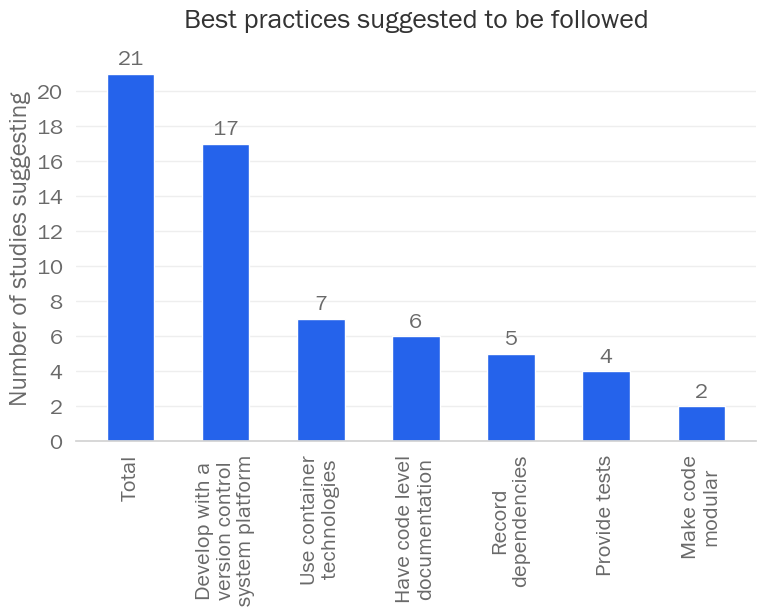

In [58]:
# Visualize results
x = ["Total"] + list(frequency.keys())
y = [total_studies] + list(frequency.values())
fig_width = 8
fig_height = 6.5
bar_width = 0.5
delta_y = 0.5
x_label = ""
y_label = "Number of studies suggesting"
title = "Best practices suggested to be followed"
max_width_x_tick_labels = 16
y_ticks_increment = 2
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "best-practices-suggested"
save_image(fig, "output", plot_name, "svg")

In [59]:
# Number of studies
df_sub = df[["doiOrLink", "title", "bestPracticeHelp"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about resources to help with best practices"
)
display(df_sub)

From the reviewed studies, 4 made a suggestion about resources to help with best practices


,doiOrLink,title,bestPracticeHelp
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,https://guide.esciencecenter.nl/#/; https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1001745; https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005510
20,https://doi.org/10.5281/zenodo.4310217,"Five recommendations for ""FAIR software""",https://software.ac.uk/choosing-repository-your-software-project
57,https://coderefinery.github.io/reproducible-research/,Reproducible research,https://coderefinery.github.io/reproducible-research/dependencies/; https://coderefinery.github.io/reproducible-research/organizing-projects/; https://coderefinery.github.io/reproducible-research/environments/
66,https://doi.org/10.5281/zenodo.3233853,"The Turing Way: A handbook for reproducible, ethical and collaborative research",https://the-turing-way.netlify.app/project-design/code-styling/code-styling-tools.html


### Category 2: Include metadata

#### Metadata files suggested to be included

In [60]:
# Number of studies
df_sub = df[["doiOrLink", "title", "metadataFilesSuggestion", "added2023"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about the metadata files and ontologies to be used for a research software"
)
# display(df_sub)

From the reviewed studies, 24 made a suggestion about the metadata files and ontologies to be used for a research software


In [62]:
# Frequency of suggestions
list_suggestions = df_sub["metadataFilesSuggestion"]
list_suggestions_cleaned = []
for item in list_suggestions:
    item = item.split(";")
    item = [re.sub("[\(\[].*?[\)\]]", "", x) for x in item]
    item = [x.strip() for x in item]
    list_suggestions_cleaned.extend(item)
list_suggestions_unique = list(set(list_suggestions_cleaned))
frequency = {}
for item in list_suggestions_unique:
    df_sub2 = df_sub[df_sub["metadataFilesSuggestion"].str.contains(item)]
    frequency[item] = len(df_sub2)
    print(item, frequency[item])
    display(df_sub2)
frequency = dict(sorted(frequency.items(), key=lambda item: item[1], reverse=True))
print(frequency)

R packages DESCRIPTION file 1


,doiOrLink,title,metadataFilesSuggestion,added2023
5,https://doi.org/10.3233/DS-190026,Towards FAIR principles for research software,biotoolsSchema; CodeMeta; Bioschemas; R packages DESCRIPTION file; PEP 566 Metadata for Python Packages; Software Ontology; EDAM; PROV-O; RDA Research Schemas,no


RDA Research Schemas 1


,doiOrLink,title,metadataFilesSuggestion,added2023
5,https://doi.org/10.3233/DS-190026,Towards FAIR principles for research software,biotoolsSchema; CodeMeta; Bioschemas; R packages DESCRIPTION file; PEP 566 Metadata for Python Packages; Software Ontology; EDAM; PROV-O; RDA Research Schemas,no


Bibtex 1


,doiOrLink,title,metadataFilesSuggestion,added2023
24,https://doi.org/10.37044/osf.io/k8znb,ELIXIR Software Management Plan for Life Sciences,CodeMeta; Citation File Format; Bibtex; EDAM,yes


PEP 566 Metadata for Python Packages 1


,doiOrLink,title,metadataFilesSuggestion,added2023
5,https://doi.org/10.3233/DS-190026,Towards FAIR principles for research software,biotoolsSchema; CodeMeta; Bioschemas; R packages DESCRIPTION file; PEP 566 Metadata for Python Packages; Software Ontology; EDAM; PROV-O; RDA Research Schemas,no


EDAM 4


,doiOrLink,title,metadataFilesSuggestion,added2023
5,https://doi.org/10.3233/DS-190026,Towards FAIR principles for research software,biotoolsSchema; CodeMeta; Bioschemas; R packages DESCRIPTION file; PEP 566 Metadata for Python Packages; Software Ontology; EDAM; PROV-O; RDA Research Schemas,no
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,CodeMeta; EDAM; Bioschemas,no
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,CodeMeta; EDAM; Citation File Format,no
24,https://doi.org/10.37044/osf.io/k8znb,ELIXIR Software Management Plan for Life Sciences,CodeMeta; Citation File Format; Bibtex; EDAM,yes


A CITATION file 2


,doiOrLink,title,metadataFilesSuggestion,added2023
56,https://libguides.mit.edu/software,Citing & publishing software: Publishing research software,A CITATION file,no
59,https://doi.org/10.1371/journal.pcbi.1005510,Good enough practices in scientific computing,A CITATION file,no


Bioschemas 2


,doiOrLink,title,metadataFilesSuggestion,added2023
5,https://doi.org/10.3233/DS-190026,Towards FAIR principles for research software,biotoolsSchema; CodeMeta; Bioschemas; R packages DESCRIPTION file; PEP 566 Metadata for Python Packages; Software Ontology; EDAM; PROV-O; RDA Research Schemas,no
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,CodeMeta; EDAM; Bioschemas,no


Software Ontology 1


,doiOrLink,title,metadataFilesSuggestion,added2023
5,https://doi.org/10.3233/DS-190026,Towards FAIR principles for research software,biotoolsSchema; CodeMeta; Bioschemas; R packages DESCRIPTION file; PEP 566 Metadata for Python Packages; Software Ontology; EDAM; PROV-O; RDA Research Schemas,no


Citation File Format 13


,doiOrLink,title,metadataFilesSuggestion,added2023
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,CodeMeta; EDAM; Citation File Format,no
20,https://doi.org/10.5281/zenodo.4310217,"Five recommendations for ""FAIR software""",CodeMeta; Citation File Format,no
21,https://arxiv.org/abs/1905.08674,Software Citation Implementation Challenges,CodeMeta; Citation File Format,yes
23,https://doi.org/10.1109/eScience.2018.00016,Research Software Discovery: An Overview,CodeMeta; Citation File Format,yes
24,https://doi.org/10.37044/osf.io/k8znb,ELIXIR Software Management Plan for Life Sciences,CodeMeta; Citation File Format; Bibtex; EDAM,yes
29,https://doi.org/10.1515/itit-2019-0040,From FAIR research data toward FAIR and open research software,Citation File Format; CodeMeta,no
32,https://doi.org/10.12688/f1000research.23224.2,"An Environment for Sustainable Research Software in Germany and beyond: Current State, Open Challenges, and Call for Action",Citation File Format; CodeMeta,no
40,https://doi.org/10.5281/zenodo.6258366,FAIR4RS: Adoption support,Citation File Format,yes
53,https://datascience.nih.gov/tools-and-analytics/best-practices-for-sharing-research-software-faq,Best Practices for Sharing Research Software,Citation File Format,no
58,https://doi.org/10.1371/journal.pcbi.1006561,Ten simple rules for documenting scientific software,Citation File Format,no


PROV-O 1


,doiOrLink,title,metadataFilesSuggestion,added2023
5,https://doi.org/10.3233/DS-190026,Towards FAIR principles for research software,biotoolsSchema; CodeMeta; Bioschemas; R packages DESCRIPTION file; PEP 566 Metadata for Python Packages; Software Ontology; EDAM; PROV-O; RDA Research Schemas,no


CodeMeta 17


,doiOrLink,title,metadataFilesSuggestion,added2023
0,https://doi.org/10.1038/s41597-022-01710-x,Introducing the FAIR Principles for research software,CodeMeta,yes
2,https://doi.org/10.15497/RDA00065,FAIR Principles for Research Software (FAIR4RS Principles),CodeMeta,no
4,https://arxiv.org/abs/2101.10883v4,A Fresh Look at FAIR for Research Software,CodeMeta,yes
5,https://doi.org/10.3233/DS-190026,Towards FAIR principles for research software,biotoolsSchema; CodeMeta; Bioschemas; R packages DESCRIPTION file; PEP 566 Metadata for Python Packages; Software Ontology; EDAM; PROV-O; RDA Research Schemas,no
6,https://doi.org/10.5281/zenodo.4095092,M2.15 Assessment report on 'FAIRness of software,CodeMeta,no
10,https://doi.org/10.2777/28598,Scholarly infrastructures for research software,CodeMeta,no
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,CodeMeta; EDAM; Bioschemas,no
15,https://doi.org/10.5281/zenodo.1324296,D3.1 Survey of Current PID Services Landscape,CodeMeta,no
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,CodeMeta; EDAM; Citation File Format,no
20,https://doi.org/10.5281/zenodo.4310217,"Five recommendations for ""FAIR software""",CodeMeta; Citation File Format,no


biotoolsSchema 1


,doiOrLink,title,metadataFilesSuggestion,added2023
5,https://doi.org/10.3233/DS-190026,Towards FAIR principles for research software,biotoolsSchema; CodeMeta; Bioschemas; R packages DESCRIPTION file; PEP 566 Metadata for Python Packages; Software Ontology; EDAM; PROV-O; RDA Research Schemas,no


{'CodeMeta': 17, 'Citation File Format': 13, 'EDAM': 4, 'A CITATION file': 2, 'Bioschemas': 2, 'R packages DESCRIPTION file': 1, 'RDA Research Schemas': 1, 'Bibtex': 1, 'PEP 566 Metadata for Python Packages': 1, 'Software Ontology': 1, 'PROV-O': 1, 'biotoolsSchema': 1}


'Saved successfully'

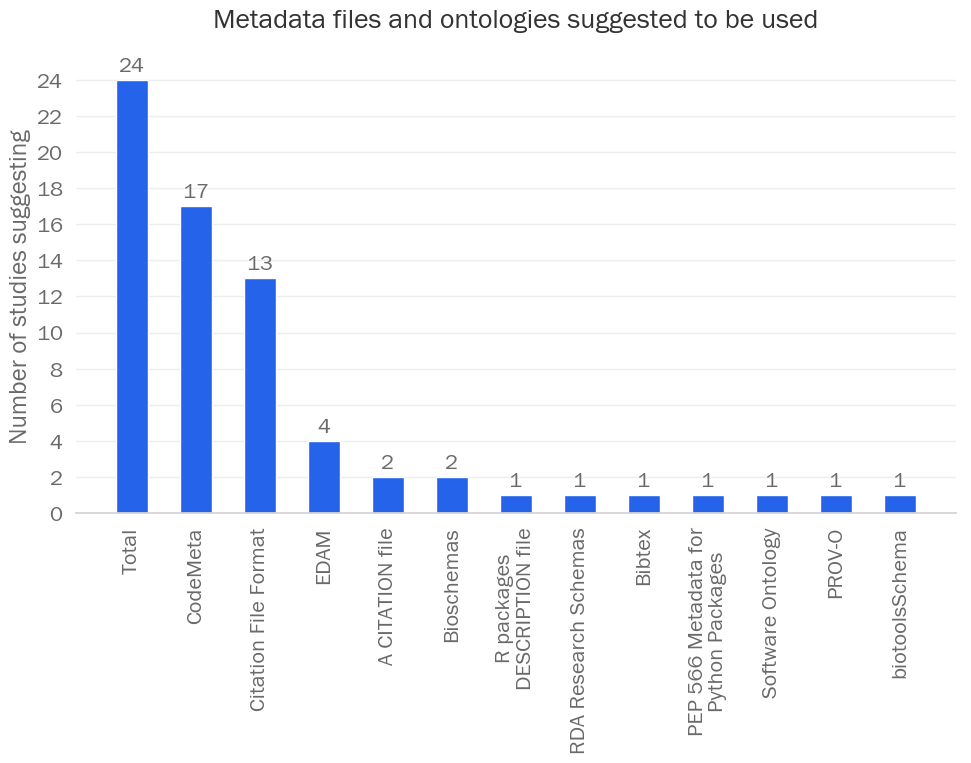

In [63]:
# Visualize results
x = ["Total"] + list(frequency.keys())
y = [total_studies] + list(frequency.values())
fig_width = 10
fig_height = 8
bar_width = 0.5
delta_y = 0.5
x_label = ""
y_label = "Number of studies suggesting"
title = "Metadata files and ontologies suggested to be used"
max_width_x_tick_labels = 20
y_ticks_increment = 2
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "metadata-files-suggested"
save_image(fig, "output", plot_name, "svg")

#### Best practices for documentation

In [64]:
df_sub = df[["doiOrLink", "title", "documentationSuggestion", "added2023"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about documenting a research software"
)
display(df_sub)

From the reviewed studies, 9 made a suggestion about documenting a research software


,doiOrLink,title,documentationSuggestion,added2023
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,README; GitHub pages; ReadTheDoc,no
20,https://doi.org/10.5281/zenodo.4310217,"Five recommendations for ""FAIR software""",README,no
24,https://doi.org/10.37044/osf.io/k8znb,ELIXIR Software Management Plan for Life Sciences,\nREADME; CHANGELOG; User documentation; Programmer documentation; API documentation; \n\n,yes
31,https://doi.org/10.2218/ijdc.v15i1.698,Curated Archiving of Research Software Artifacts: lessons learned from the French open archive,README,no
57,https://coderefinery.github.io/reproducible-research/,Reproducible research,README,no
58,https://doi.org/10.1371/journal.pcbi.1006561,Ten simple rules for documenting scientific software,README,no
59,https://doi.org/10.1371/journal.pcbi.1005510,Good enough practices in scientific computing,README,no
66,https://doi.org/10.5281/zenodo.3233853,"The Turing Way: A handbook for reproducible, ethical and collaborative research",README,yes
67,https://doi.org/10.48440/os.helmholtz.041,Model Policy on Sustainable Software at the Helmholtz Centers,README,yes


In [65]:
df_sub = df[["doiOrLink", "title", "documentationHelp", "added2023"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about resources to help with documenting a research software"
)
display(df_sub)

From the reviewed studies, 11 made a suggestion about resources to help with documenting a research software


,doiOrLink,title,documentationHelp,added2023
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,Write the Docs page explains and gives examples of good documentation: https://www.writethedocs.org/guide/writing/beginners-guide-to-docs/,no
24,https://doi.org/10.37044/osf.io/k8znb,ELIXIR Software Management Plan for Life Sciences,"The actual scope, goals and purpose of the software needs\nto be defined and documented. \n\nDocumented information on how the software can be reliably used by\npeople external to the development group or person.\n\nDo you state how to report bugs and/or usability problems by the software user(s)? This could be a simple sentence in the software documentation, stating an email, or an issue tracker, or a direct messaging protocol, or even a statement that bug reporting/issues are not supported",yes
32,https://doi.org/10.12688/f1000research.23224.2,"An Environment for Sustainable Research Software in Germany and beyond: Current State, Open Challenges, and Call for Action",Doxygen,no
52,https://doi.org/10.12688/f1000research.10750.2,General guidelines for biomedical software development,Sphinx3; Javadoc,no
53,https://datascience.nih.gov/tools-and-analytics/best-practices-for-sharing-research-software-faq,Best Practices for Sharing Research Software,https://bssw.io/items?topic=documentation,no
58,https://doi.org/10.1371/journal.pcbi.1006561,Ten simple rules for documenting scientific software,Sphinx; perldoc; Javadoc; Roxygen,no
63,https://doi.org/10.15497/rda00052,RDA COVID-19 Recommendations and Guidelines on Data Sharing,Ten simple rules for documenting scientific software,no
64,http://doi.org/10.5281/zenodo.4706164,Software Citation Checklist,"Plan to capture information that will be vital to describing and citing your software later including authors (contributors), project/software name, releases (versions), coding standards, dependencies, frameworks, tests, and sustainability",yes
65,https://doi.org/10.5281/zenodo.2159713,Checklist for a Software Management Plan,"It is always good to make clear what, if any, support you will provide clear on your website or in your documentation, e.g. ""we will reply to all e-mails within a week and will let you know when, or if, we can address your issue""\n\nWhen developing research software, it is good to be able to explain how it will contribute to research, whether this is research to be done by yourself or by others using your research software.",yes
66,https://doi.org/10.5281/zenodo.3233853,"The Turing Way: A handbook for reproducible, ethical and collaborative research","file containing useful information about a project such as what it is, how to use/install it and how to run any tests. If you want others to collaborate on the project include contribution guidelines.\n\nDocument the tests and how to run them.\n\nInclude an example citation in your software manual",yes


### Category 3: Provide a license

In [66]:
# Number of studies
df_sub = df[["doiOrLink", "title", "licenseSuggestion", "added2023"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about the licenses to be used for sharing a research software"
)
display(df_sub)

From the reviewed studies, 18 made a suggestion about the licenses to be used for sharing a research software


,doiOrLink,title,licenseSuggestion,added2023
0,https://doi.org/10.1038/s41597-022-01710-x,Introducing the FAIR Principles for research software,Apache 2.0; GNU GPL v3,yes
2,https://doi.org/10.15497/RDA00065,FAIR Principles for Research Software (FAIR4RS Principles),Open source licenses,no
5,https://doi.org/10.3233/DS-190026,Towards FAIR principles for research software,Open source licenses; Permissive licenses,no
10,https://doi.org/10.2777/28598,Scholarly infrastructures for research software,Open source licenses,no
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,OSI-approved licenses,no
20,https://doi.org/10.5281/zenodo.4310217,"Five recommendations for ""FAIR software""",Apache 2.0; MIT,no
29,https://doi.org/10.1515/itit-2019-0040,From FAIR research data toward FAIR and open research software,Open source licenses,no
31,https://doi.org/10.2218/ijdc.v15i1.698,Curated Archiving of Research Software Artifacts: lessons learned from the French open archive,Licenses from the SPDX referential catalog,no
32,https://doi.org/10.12688/f1000research.23224.2,"An Environment for Sustainable Research Software in Germany and beyond: Current State, Open Challenges, and Call for Action",FSF-approved licenses; OSI-approved licenses; Apache 2.0; MIT,no
35,https://doi.org/10.12688/f1000research.26932.2,The Importance of Software Citation,Open source licenses,no


In [67]:
# Frequency of suggestions
frequency = frenquency_suggestions(df_sub["licenseSuggestion"])
print(frequency)

{'Open source licenses': 9, 'Apache 2.0': 6, 'MIT': 4, 'OSI-approved licenses': 3, 'Permissive licenses': 2, 'BSD': 2, 'GNU GPL v3': 1, 'Licenses from the SPDX referential catalog': 1, 'FSF-approved licenses': 1, 'EUPL': 1, 'AGPL': 1, 'LGPL': 1, 'GPL': 1, 'CC0': 1}


'Saved successfully'

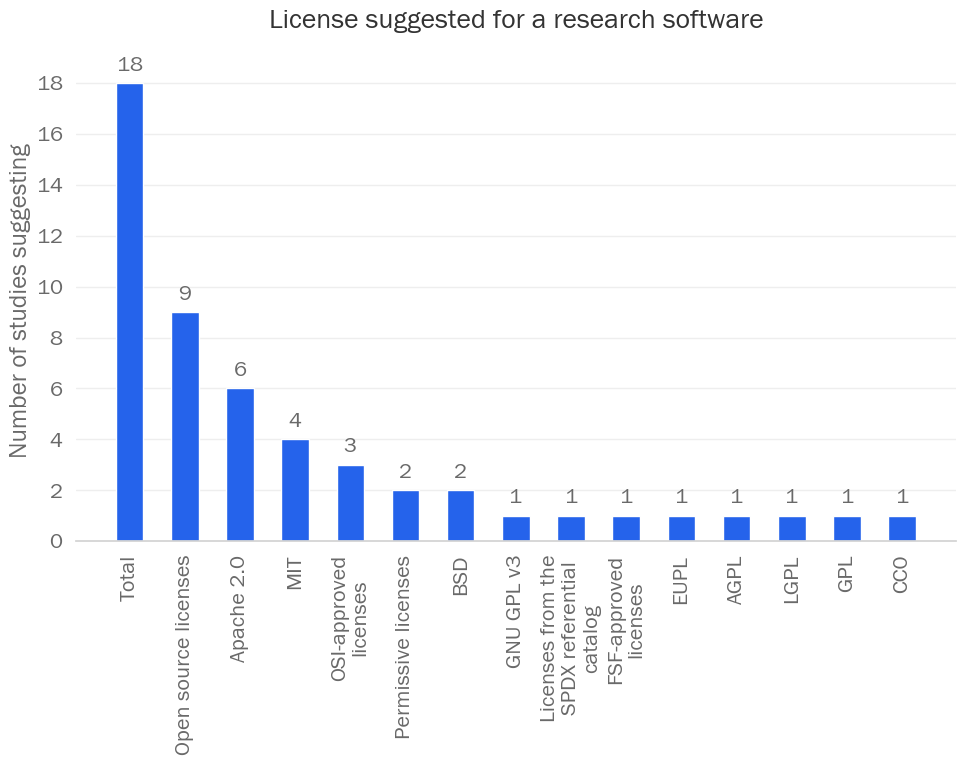

In [68]:
# Visualize results
x = ["Total"] + list(frequency.keys())
y = [total_studies] + list(frequency.values())
fig_width = 10
fig_height = 8
bar_width = 0.5
delta_y = 0.5
x_label = ""
y_label = "Number of studies suggesting"
title = "License suggested for a research software"
max_width_x_tick_labels = 20
y_ticks_increment = 2
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "license-suggested"
save_image(fig, "output", plot_name, "svg")

In [69]:
df_sub = df[["doiOrLink", "title", "licenseHelp", "added2023"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about resources to help with license"
)
display(df_sub)

From the reviewed studies, 19 made a suggestion about resources to help with license


,doiOrLink,title,licenseHelp,added2023
1,https://doi.org/10.15497/RDA00068,FAIR Principles for Research Software (FAIR4RS Principles) v 1.0,"https://spdx.dev/; The FAIR4RS Principles can be applied to any research software, regardless of the license. To support a wide range of reuse scenarios, the license should be as unrestrictive as possible and, to avoid license proliferation",yes
2,https://doi.org/10.15497/RDA00065,FAIR Principles for Research Software (FAIR4RS Principles),https://spdx.dev/,no
5,https://doi.org/10.3233/DS-190026,Towards FAIR principles for research software,https://spdx.dev/,no
6,https://doi.org/10.5281/zenodo.4095092,M2.15 Assessment report on 'FAIRness of software,https://spdx.dev/; https://reuse.software/,no
10,https://doi.org/10.2777/28598,Scholarly infrastructures for research software,https://spdx.dev/,no
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,"https://choosealicense.com/; http://oss-watch.ac.uk/;_x000D_\n_x000D_\nMost of the projects places their license information in a file named LICENSE (LICENSE.txt or LICENSE.md or LICENSE.rst or COPYING, COPYING.txt, COPYING.md, COPYING.rst are also used) in the root of the repository.",no
15,https://doi.org/10.5281/zenodo.1324296,D3.1 Survey of Current PID Services Landscape,https://spdx.dev/,no
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,https://choosealicense.com/; https://softdev4research.github.io/4OSS-lesson/03-use-license/index.html,no
20,https://doi.org/10.5281/zenodo.4310217,"Five recommendations for ""FAIR software""",https://choosealicense.com/; https://tldrlegal.com/,no
31,https://doi.org/10.2218/ijdc.v15i1.698,Curated Archiving of Research Software Artifacts: lessons learned from the French open archive,https://spdx.dev/,no


### Category 4: Share software in a repository

#### Files suggested to be shared

In [70]:
# Number of studies
df_sub = df[["doiOrLink", "title", "dataFileSuggestion", "added2023"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about the files to be shared for a research software"
)
display(df_sub)

From the reviewed studies, 9 made a suggestion about the files to be shared for a research software


,doiOrLink,title,dataFileSuggestion,added2023
1,https://doi.org/10.15497/RDA00068,FAIR Principles for Research Software (FAIR4RS Principles) v 1.0,Source code; Binaries; Containers,yes
3,https://doi.org/10.1016/j.patter.2021.100222,Taking a fresh look at FAIR for research software,Source code; Executable,no
4,https://arxiv.org/abs/2101.10883v4,A Fresh Look at FAIR for Research Software,Source code,yes
19,https://doi.org/10.3389/fninf.2017.00069,"Re-run, repeat, reproduce, reuse, replicate: Transforming code into scientific contributions",Source code; Input data; Output data,no
24,https://doi.org/10.37044/osf.io/k8znb,ELIXIR Software Management Plan for Life Sciences,Input data; Output data,yes
48,https://doi.org/10.1371/journal.pone.0213013,Reproducible big data science: A case study in continuous FAIRness,Source code,no
53,https://datascience.nih.gov/tools-and-analytics/best-practices-for-sharing-research-software-faq,Best Practices for Sharing Research Software,Source code; Executable,no
54,https://doi.org/10.3389/fgene.2014.00199,On best practices in the development of bioinformatics software,Source code; Input data; Output data,no
65,https://doi.org/10.5281/zenodo.2159713,Checklist for a Software Management Plan,Source code,yes


In [71]:
# Frequency of suggestions
frequency = frenquency_suggestions(df_sub["dataFileSuggestion"])
print(frequency)

{'Source code': 8, 'Input data': 3, 'Output data': 3, 'Executable': 2, 'Binaries': 1, 'Containers': 1}


In [72]:
df_sub["dataFileSuggestion"]

1        Source code; Binaries; Containers
3                  Source code; Executable
4                              Source code
19    Source code; Input data; Output data
24                 Input data; Output data
48                             Source code
53                 Source code; Executable
54    Source code; Input data; Output data
65                             Source code
Name: dataFileSuggestion, dtype: object

'Saved successfully'

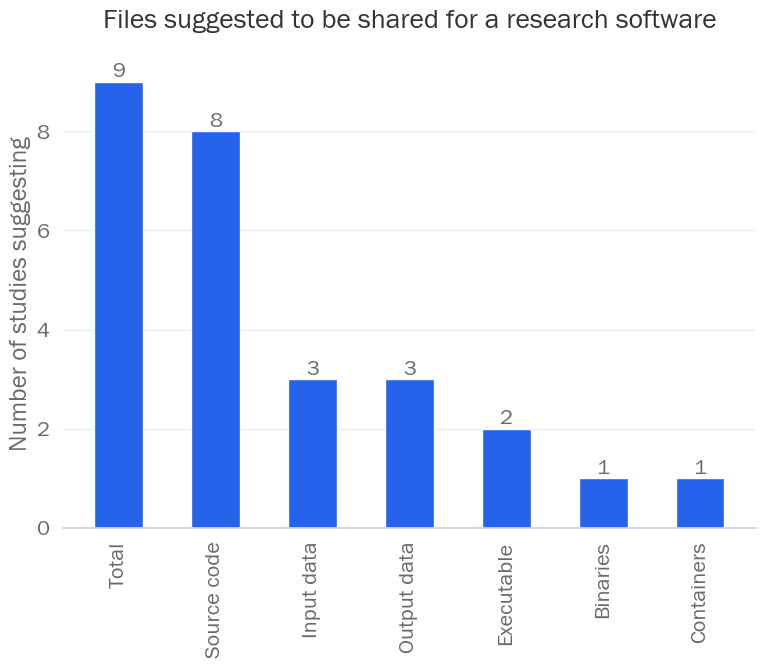

In [73]:
# Visualize results
x = ["Total"] + list(frequency.keys())
y = [total_studies] + list(frequency.values())
fig_width = 8
fig_height = 7
bar_width = 0.5
delta_y = 0.1
x_label = ""
y_label = "Number of studies suggesting"
title = "Files suggested to be shared for a research software"
max_width_x_tick_labels = 16
y_ticks_increment = 2
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "files-suggested"
save_image(fig, "output", plot_name, "svg")

In [74]:
# Number of studies
df_sub = df[["doiOrLink", "title", "licenseHelp"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about resources to help with selecting a license for research software"
)

From the reviewed studies, 19 made a suggestion about resources to help with selecting a license for research software


### Repositories suggested to be used

In [75]:
# Number of studies
df_sub = df[["doiOrLink", "title", "repositorySuggestion", "added2023"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about a repository to use for sharing research software"
)
display(df_sub)

From the reviewed studies, 27 made a suggestion about a repository to use for sharing research software


,doiOrLink,title,repositorySuggestion,added2023
0,https://doi.org/10.1038/s41597-022-01710-x,Introducing the FAIR Principles for research software,Zenodo; HAL; Software Heritage,yes
4,https://arxiv.org/abs/2101.10883v4,A Fresh Look at FAIR for Research Software,Zenodo; Software Heritage,yes
5,https://doi.org/10.3233/DS-190026,Towards FAIR principles for research software,Zenodo; Software Heritage; CRAN; PyPI; Conda; Figshare; Bioconductor,no
6,https://doi.org/10.5281/zenodo.4095092,M2.15 Assessment report on 'FAIRness of software,Zenodo; HAL; Software Heritage; CRAN; PyPI,no
10,https://doi.org/10.2777/28598,Scholarly infrastructures for research software,Software Heritage; HAL; Zenodo,no
12,https://doi.org/10.7717/peerj-cs.86,Software citation principles,Figshare; Zenodo,no
15,https://doi.org/10.5281/zenodo.1324296,D3.1 Survey of Current PID Services Landscape,Zenodo; Software Heritage,no
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,Zenodo; Software Heritage; PyPI; CRAN,no
19,https://doi.org/10.3389/fninf.2017.00069,"Re-run, repeat, reproduce, reuse, replicate: Transforming code into scientific contributions",Figshare; Zenodo; ModelDB,no
20,https://doi.org/10.5281/zenodo.4310217,"Five recommendations for ""FAIR software""",Zenodo; Figshare; Software Heritage,no


In [76]:
# Frequency of suggestions
frequency = frenquency_suggestions(df_sub["repositorySuggestion"])
print(frequency)

{'Zenodo': 25, 'Software Heritage': 12, 'Figshare': 11, 'CRAN': 5, 'HAL': 4, 'PyPI': 3, 'Conda': 2, 'Bioconductor': 2, 'ModelDB': 1, 'Mendeley Data': 1, 'Dockstore': 1, 'NanoHub': 1, 'Dataverse': 1}


'Saved successfully'

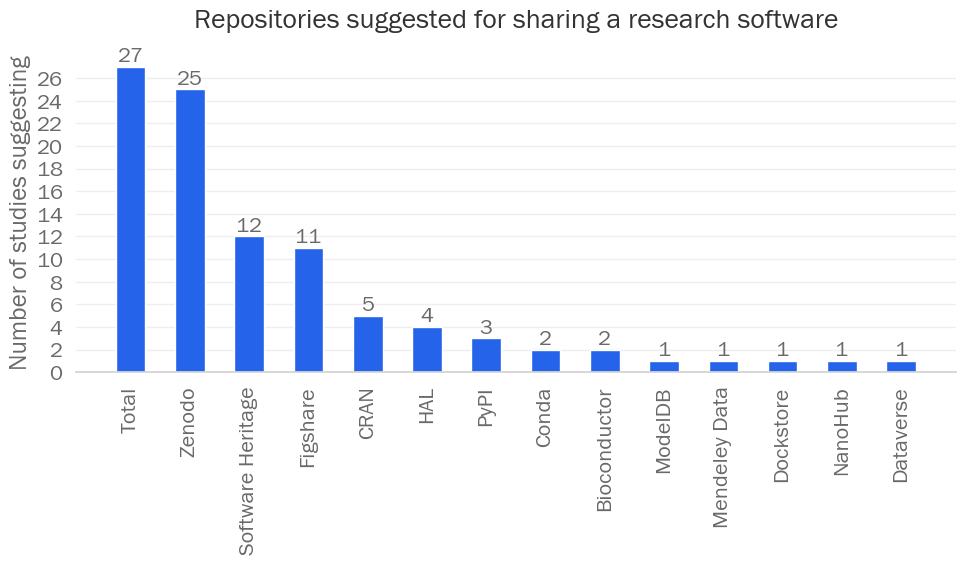

In [77]:
# Visualize results
x = ["Total"] + list(frequency.keys())
y = [total_studies] + list(frequency.values())
fig_width = 10
fig_height = 6
bar_width = 0.5
delta_y = 0.5
x_label = ""
y_label = "Number of studies suggesting"
title = "Repositories suggested for sharing a research software"
max_width_x_tick_labels = 20
y_ticks_increment = 2
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "repositories-suggested"
save_image(fig, "output", plot_name, "svg")

### Category 5: Register on a registry

In [78]:
# Number of studies
df_sub = df[["doiOrLink", "title", "registerySuggestion", "added2023"]].dropna()
total_studies = len(df_sub)
print(
    "From the reviewed studies, "
    + str(total_studies)
    + " made a suggestion about the registeries to use for a research software"
)
display(df_sub)

From the reviewed studies, 8 made a suggestion about the registeries to use for a research software


,doiOrLink,title,registerySuggestion,added2023
0,https://doi.org/10.1038/s41597-022-01710-x,Introducing the FAIR Principles for research software,bio.tools; Research Software Directory,yes
4,https://arxiv.org/abs/2101.10883v4,A Fresh Look at FAIR for Research Software,Zenodo,yes
5,https://doi.org/10.3233/DS-190026,Towards FAIR principles for research software,Zenodo; Software Heritage; CRAN; PyPI; Figshare; BioConductor; bio.tools; Conda; BioContainers,no
6,https://doi.org/10.5281/zenodo.4095092,M2.15 Assessment report on 'FAIRness of software,Zenodo; HAL; Software Heritage; CRAN; PyPI,no
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,bio.tools; biojs.io; Omic Tools; DataCite; BioCatalogue,no
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,bio.tools; Research Software Directory; rOpenSci Project; Zenodo,no
21,https://arxiv.org/abs/1905.08674,Software Citation Implementation Challenges,SciCrunch,yes
42,https://doi.org/10.5281/zenodo.6374314,FAIR4RS Software (FAIR4RS),Research Software Directory; PyPI; Conda-forge,yes


In [79]:
# Frequency of suggestions
frequency = frenquency_suggestions(df_sub["registerySuggestion"])
print(frequency)

{'bio.tools': 4, 'Zenodo': 4, 'Research Software Directory': 3, 'PyPI': 3, 'Software Heritage': 2, 'CRAN': 2, 'Figshare': 1, 'BioConductor': 1, 'Conda': 1, 'BioContainers': 1, 'HAL': 1, 'biojs.io': 1, 'Omic Tools': 1, 'DataCite': 1, 'BioCatalogue': 1, 'rOpenSci Project': 1, 'SciCrunch': 1, 'Conda-forge': 1}


'Saved successfully'

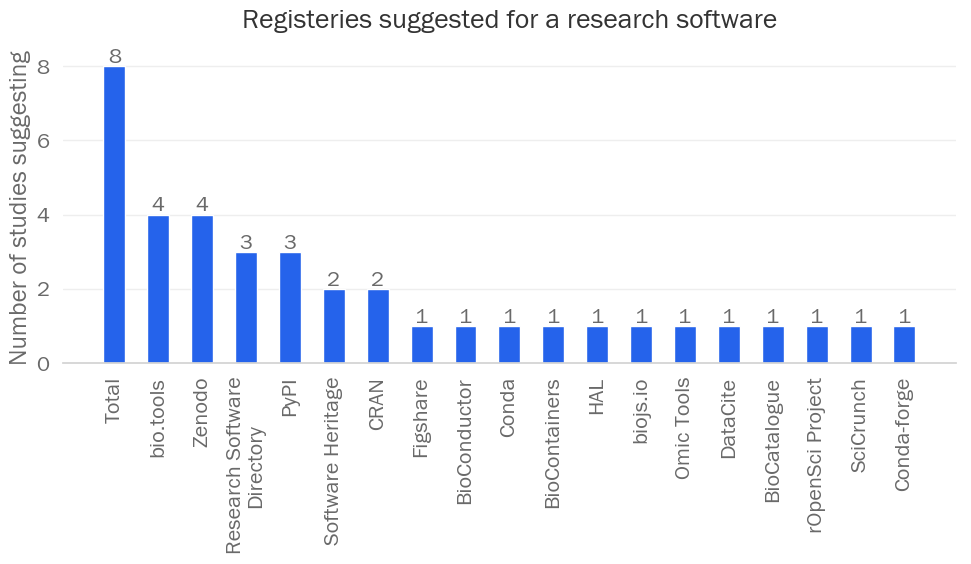

In [80]:
# Visualize results
x = ["Total"] + list(frequency.keys())
y = [total_studies] + list(frequency.values())
fig_width = 10
fig_height = 6
bar_width = 0.5
delta_y = 0.1
x_label = ""
y_label = "Number of studies suggesting"
title = "Registeries suggested for a research software"
max_width_x_tick_labels = 20
y_ticks_increment = 2
fig = generate_bar_plot(
    x,
    y,
    fig_width,
    fig_height,
    bar_width,
    delta_y,
    x_label,
    y_label,
    title,
    max_width_x_tick_labels,
    y_ticks_increment,
)
plot_name = "registeries-suggested"
save_image(fig, "output", plot_name, "svg")